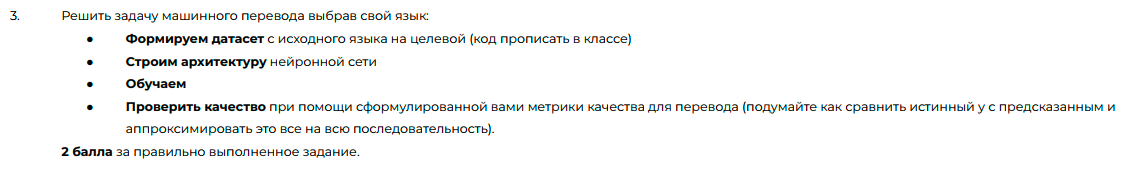

In [25]:
from io import open
import unicodedata
import string
import re
import random
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from nltk.translate.bleu_score import corpus_bleu
import math
import time
import tqdm
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.switch_backend('agg')
import warnings
warnings.filterwarnings("ignore")

In [2]:
BATCH_SIZE = 50
MAX_LENGTH = 20
NUM_EPOCHS = 20
LEARNING_RATE = 1e-2
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SOS_token = 0
EOS_token = 1
DEVICE

device(type='cuda')

In [3]:
from google.colab import drive

In [4]:
drive.mount('/drive')

Mounted at /drive


In [5]:
!pip install anyascii
# https://github.com/anyascii/
# https://www.geeksforgeeks.org/convert-unicode-to-ascii-in-python/

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 287 kB 8.6 MB/s 


In [6]:
from anyascii import anyascii
# print("The ASCII from Symbols : " + str(anyascii(sym_uni)))

In [7]:
def normalize_string(s):
    return str(anyascii(s)).lower().strip()

# Building vocabulary

In [8]:
available_lang_voc = {
            'bel' : 'Belarusian',
            'ukr' : 'Ukrainian',
            'rus' : 'Russian',
            'pol' : 'Polish',
            'cmn' : 'Chinease (Mandarin)',
            'ita' : 'Italian',
            'deu' : 'Deutsch',
            'nld' : 'Dutch',
            'afr' : 'African'
        }

In [9]:
class Language():

    def __init__(self, lang_short_name='eng'):

        self.short_name = lang_short_name
        if lang_short_name=='eng':
            self.name = 'English'
        else:
            self.name = available_lang_voc[lang_short_name]

        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2

    def add_sentence(self, sentence):
        for word in sentence.split(' '):
            self.add_word(word)

    def add_word(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

    def __str__(self):
        description = "{} ({})\nCounted words:\n{}".format(self.name, self.short_name, self.n_words)
        return description

In [10]:
# Class to read file and build languages dataset to translate (to/from English)
class LanguageVocabulary():

    def __init__(self, lang_short_name, reverse=False):
        
        if lang_short_name not in available_lang_voc.keys():
            print("Available languages:")
            for k, v in available_lang_voc.items():
                print("{} => {}".format(k, v))
            raise NameError('Please provide one of the available languages (short mnemonic)')
        
        self.reverse = reverse
        if reverse:
            self.input_lang = Language() # 'eng'
            self.output_lang = Language(lang_short_name)
        else:
            self.input_lang = Language(lang_short_name)
            self.output_lang = Language() # 'eng'

        self.pairs = self.fill_vocabulary(lang_short_name, reverse)
        self.pairs_count = len(self.pairs)

        for pair in self.pairs:
            self.input_lang.add_sentence(pair[0])
            self.output_lang.add_sentence(pair[1])

    def fill_vocabulary(self, short_name, reverse):
        # read file
        lines = open("/drive/My Drive/translation_data/{}.txt".format(short_name), encoding='utf-8').read().strip().split('\n')

        # Only first 2 columns separated by tab is essencial
        pairs = [[normalize_string(s) for s in l.split('\t')[:2]] for l in lines]

        if reverse:
            pairs = [list(reversed(p)) for p in pairs]
        
        return pairs

    def prepare_data(self, input_lang, output_lang, pairs):
        
        for pair in pairs:
            input_lang.add_sentence(pair[0])
            output_lang.add_sentence(pair[1])
        
        print("Counted words:")
        print(input_lang.name, input_lang.n_words)
        print(output_lang.name, output_lang.n_words)
        return input_lang, output_lang, pairs

    def __str__(self):
        description = "Vocabulary: {} <=> {}\nContains {} sentence pairs\nInput language:{}\nOutput language:{}".format(self.input_lang.name, self.output_lang.name,
                                                                                                                 self.pairs_count, 
                                                                                                                 self.input_lang,
                                                                                                                 self.output_lang)
        return description

In [11]:
vocab = LanguageVocabulary('ukr')
print(vocab)

Vocabulary: Ukrainian <=> English
Contains 156173 sentence pairs
Input language:Ukrainian (ukr)
Counted words:
18609
Output language:English (eng)
Counted words:
46888


In [12]:
print(random.choice(vocab.pairs))

['did you walk from the station?', 'ti priyshov iz vokzalu pishki?']


# Encoder

In [13]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=DEVICE)

# Decoder

In [14]:
class AttentionDecoder(nn.Module):
    
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttentionDecoder, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=DEVICE)

### Utilites

In [15]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=DEVICE).view(-1, 1)

def tensorsFromPair(pair, input_lang, output_lang):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

In [16]:
def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / percent
    rs = es - s
    return '%s (- eta: %s)' % (asMinutes(s), asMinutes(rs))

In [17]:
def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

## Training function for ONE pair

In [18]:
teacher_forcing_ratio = 0.5

def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):

    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    # Encoder
    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=DEVICE)
    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(input_tensor[ei], 
                                                 encoder_hidden)
        #encoder_outputs[ei] = encoder_output[0, 0]

    # Decoder
    decoder_input = torch.tensor([[SOS_token]], device=DEVICE)
    decoder_hidden = encoder_hidden

    # Teacher Forcing
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False
    if use_teacher_forcing:

        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing
    else:
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input
            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break
    loss.backward()
    encoder_optimizer.step()
    decoder_optimizer.step()
    return loss.item() / target_length

## Training all pairs

In [19]:
def trainIters(encoder, decoder, n_iters, vocab, print_every=1000, plot_every=100, learning_rate=LEARNING_RATE):
    pairs, input_lang, output_lang = vocab.pairs, vocab.input_lang, vocab.output_lang
    
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    
    training_pairs = [tensorsFromPair(random.choice(pairs), input_lang, output_lang) for i in range(n_iters)]
    # FYI! Используем Negative Log-Likelihood Loss потому что log softmax уже присутствует в модели
    criterion = nn.NLLLoss()

    for epoch in range(1, n_iters + 1):
        training_pair = training_pairs[epoch - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]
        
        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if epoch % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, epoch / n_iters),
                                         epoch, epoch / n_iters * 100, print_loss_avg))

        if epoch % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0
    showPlot(plot_losses)

In [20]:
#from zmq.backend import device
def evaluate(encoder, decoder, sentence, input_lang, output_lang, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=DEVICE)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=DEVICE)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

In [22]:
hidden_size = 512
encoder1 = EncoderRNN(vocab.input_lang.n_words, hidden_size).to(DEVICE)
decoder1 = AttentionDecoder(hidden_size, vocab.output_lang.n_words, dropout_p=0.1).to(DEVICE)
trainIters(encoder1, decoder1, 105000, vocab)

0m 40s (- eta: 70m 38s) (1000 0%) 6.0197
1m 13s (- eta: 63m 23s) (2000 1%) 5.6373
1m 47s (- eta: 60m 55s) (3000 2%) 5.5456
2m 21s (- eta: 59m 30s) (4000 3%) 5.3984
2m 55s (- eta: 58m 37s) (5000 4%) 5.3500
3m 30s (- eta: 57m 54s) (6000 5%) 5.2310
4m 5s (- eta: 57m 18s) (7000 6%) 5.1920
4m 40s (- eta: 56m 40s) (8000 7%) 5.1517
5m 15s (- eta: 56m 1s) (9000 8%) 5.0111
5m 50s (- eta: 55m 27s) (10000 9%) 4.9742
6m 25s (- eta: 54m 52s) (11000 10%) 4.9181
7m 0s (- eta: 54m 17s) (12000 11%) 4.8456
7m 35s (- eta: 53m 43s) (13000 12%) 4.8683
8m 11s (- eta: 53m 12s) (14000 13%) 4.7103
8m 46s (- eta: 52m 40s) (15000 14%) 4.7111
9m 22s (- eta: 52m 8s) (16000 15%) 4.6744
9m 58s (- eta: 51m 38s) (17000 16%) 4.5689
10m 34s (- eta: 51m 7s) (18000 17%) 4.5185
11m 9s (- eta: 50m 32s) (19000 18%) 4.4937
11m 45s (- eta: 49m 58s) (20000 19%) 4.4887
12m 21s (- eta: 49m 24s) (21000 20%) 4.3995
12m 56s (- eta: 48m 50s) (22000 20%) 4.3544
13m 32s (- eta: 48m 18s) (23000 21%) 4.2720
14m 9s (- eta: 47m 45s) (24000

## Inference

In [21]:
def evaluateRandomly(encoder, decoder, vocab, n=10):
    pairs, input_lang, output_lang = vocab.pairs, vocab.input_lang, vocab.output_lang
    
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0], vocab.input_lang, vocab.output_lang, MAX_LENGTH)
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

In [23]:
# small samples
evaluateRandomly(encoder1, decoder1, vocab)

> don't worry. i'll do it.
= ne khvilyuysya, ya zroblyu tse.
< ne zroblyu ya zroblyu <EOS>

> is tom married to mary?
= tom odruzheniy z meri?
< tom odruzhivsya iz meri? <EOS>

> i don't expect you to remember.
= ya ne ochikuyu, shcho ti zapam'yataiesh.
< ya ne ochikuvav shcho ti ne <EOS>

> tom said he's not alone.
= tom skazav, shcho vin ne odin.
< tom skazav, shcho ne sam. <EOS>

> i borrowed the book from this library.
= ya pozichiv knizhku u bibliotetsi.
< ya pozichiv tsey vid knizhku. <EOS>

> i'd like to help you.
= ya khotiv bi vam dopomogti.
< ya khotila bi dopomogti. dopomogti. <EOS>

> when does tom want me to help him do that?
= koli tom khoche, shchob ya yomu dopomogla tse zrobiti?
< tom khoche, shchob vin dopomogti meni dopomogti shchob vin tse zrobiti? <EOS>

> it was too much.
= tse bulo zanadto.
< tse zanadto <EOS>

> a bear can climb trees.
= vedmedi vmiyut' zaliti po derevakh.
< mozhesh vzyati na yogo <EOS>

> he stopped talking.
= vin pripiniv govoriti.
< vin prodov

In [40]:
# get validation dataset
validation_pairs = []
val_size = 10000

for _ in range(val_size):
    validation_pairs.append(random.choice(vocab.pairs))

### BLEU (bilingual evaluation understudy) metric to evaluate quality


In [42]:
def bleu_score(encoder, decoder, validation_pairs, input_lang, output_lang):
    
    actual_array = []
    predicted_array = []

    # Get the bleu score of a model
    for pair in validation_pairs:
        actual_array.append([pair[1].split()])
        output_words, attentions = evaluate(encoder, decoder, pair[0], vocab.input_lang, vocab.output_lang, MAX_LENGTH)
        predicted_array.append(output_words)

    bleu_dic = {}
    bleu_dic['1-grams'] = corpus_bleu(actual_array, predicted_array, weights=(1.0, 0, 0, 0))
    bleu_dic['1-2-grams'] = corpus_bleu(actual_array, predicted_array, weights=(0.5, 0.5, 0, 0))
    bleu_dic['1-3-grams'] = corpus_bleu(actual_array, predicted_array, weights=(0.3, 0.3, 0.3, 0))
    bleu_dic['1-4-grams'] = corpus_bleu(actual_array, predicted_array, weights=(0.25, 0.25, 0.25, 0.25))
    
    return bleu_dic

In [43]:
bleu_metric = bleu_score(encoder1, decoder1, validation_pairs, vocab.input_lang, vocab.output_lang)

In [45]:
bleu_metric

{'1-grams': 0.42382303327710474, '1-2-grams': 0.291871103839983, '1-3-grams': 0.24141581938920567, '1-4-grams': 0.14514587774719617}

*BLUE mertic using HuggingFace*

In [47]:
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 431 kB 7.3 MB/s 
     |████████████████████████████████| 120 kB 68.9 MB/s 
     |████████████████████████████████| 115 kB 50.3 MB/s 
     |████████████████████████████████| 212 kB 66.6 MB/s 
     |████████████████████████████████| 127 kB 54.2 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [53]:
!pip install sacrebleu

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 116 kB 6.9 MB/s 


In [55]:
from datasets import load_metric

In [63]:
def get_score(encoder, decoder, metric, validation_pairs, input_lang, output_lang):
    
    actual_array = []
    predicted_array = []

    # Get the sacrebleu score of the model
    for pair in validation_pairs:
        output_words, _ = evaluate(encoder, decoder, pair[0], vocab.input_lang, vocab.output_lang, MAX_LENGTH)
        bleu_metric.add(prediction=output_words, references=[pair[1].split()])
    
    score = bleu_metric.compute()
    
    return score

In [65]:
bleu_metric = load_metric('sacrebleu')
score_result = get_score(encoder1, decoder1, bleu_metric, validation_pairs, vocab.input_lang, vocab.output_lang)

In [66]:
import pandas as pd
pd.DataFrame.from_dict(score_result, orient='index', columns=['Value'])

,Value
score,31.261421
counts,"[98510, 63809, 37643, 24184]"
totals,"[171853, 161853, 151853, 141853]"
precisions,"[57.32224633844041, 39.424045275651366, 24.789..."
bp,1.0
sys_len,171853
ref_len,136970


## ROUGE metric to evaluate quality

In [61]:
!pip install rouge_score

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24955 sha256=31c751be9a11f07ff4f6c7c1bdf21f8075e18c468fb92a3bdb371e9e3b3590ce
  Stored in directory: /root/.cache/pip/wheels/84/ac/6b/38096e3c5bf1dc87911e3585875e21a3ac610348e740409c76
Successfully built rouge-score


In [67]:
rouge_metric = load_metric('rouge')
score_result = get_score(encoder1, decoder1, bleu_metric, validation_pairs, vocab.input_lang, vocab.output_lang)
pd.DataFrame.from_dict(score_result, orient='index', columns=['Value'])

,Value
score,31.252072
counts,"[98607, 63912, 37701, 24226]"
totals,"[172129, 162129, 152129, 142129]"
precisions,"[57.28668614817956, 39.420461484373554, 24.782..."
bp,1.0
sys_len,172129
ref_len,136970
